# Fixed Income Calculator

Fixed income securities lend themselves to relatively complicated calculations given the predictability of cash flows. Complicated calculations are tedious to do, but once they are understood they can be coded and their relations explored by plugging in values to see whats the result. The below is a project that does exactly that for bond prices, yield to maturity, coupons, periodicity and duration (measured by effective duration).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Bond price calculator
The first relation we have to understand is the relation between the usual variables of a bond (facevalue, couponrate, tenor, periodicity, ytm) and its price. To do so, the below function simply discounts the coupons and the principal at the bonds yield to maturity. 

In [2]:
def bond_price(facevalue, couponrate, tenor, periodicity, ytm):
    periods = tenor*periodicity
    i = ytm/periodicity
    cr = couponrate/periodicity
    tv = list()
    for p in range(1,int(periods)): 
        tv.append((cr*facevalue)/(1+i)**p)
    value = sum(tv) + (facevalue*(1+cr))/(1+i)**periods
    return(value)

Quick explanation: Depending on the tenor and the bond's periodicity, we have to calculate the number of coupons we have to discount. Coupon rates and interest rates are stated as annual rates, so a bond with a 5% coupon at 3%=ytm that pays bi-annually (periodicity = 2). Has a bi-annual coupon of 2.5% of face value, and we would discount the first payment happening in half a year at 1.5%. 

Knowing this, we simply calculate the time value (tv) of all coupons by discounting them back to today. Since range(1,10) gives us the numbers from 1 to 9(!) we then have to add the last coupon to the facevalue of the bond, and then discount this back as well to get the bonds price. So far very basic. 

## Effective Duration calculator
The second essential property of any bonds is its interest rate sensitivity or duration. Essentially, the duration is the first derivative of the function of a bond that calculates the price given a yield to maturity. There are 3 standard ways to state duration (Macauley, Modified Duration, Effective Duration). We measure the effective duration since it is relatively straight forward to derive from observed bond prices at given interest rates. 

In [14]:
def price_ytm_curve(facevalue, couponrate, tenor, periodicity, yt_range=np.arange(0,0.1,0.001)):
    
    prices = list()
    yt = list()
    #First loop, calculate prices at various ytms.
    for item in range(0,len(yt_range)):
        prices.append(bond_price(facevalue, couponrate, tenor, periodicity, ytm = yt_range[item]))
        yt.append(yt_range[item])
    d = {'price': prices, 'YTM': yt}
    df = pd.DataFrame(data=d)
    
    
    eff_dur = pd.DataFrame()
    for i in range(1,len(df)-1):
        eff_dur.loc[i,"eff_dur"] = (df.loc[i-1,"price"]-df.loc[i+1,"price"])/(2*df.loc[i,"price"]*(df.loc[i,"YTM"]-df.loc[i-1,"YTM"]))
        eff_dur.loc[i,"price"] = df.loc[i,"price"]
    
    df = pd.merge(df, eff_dur, left_on ="price",right_on= "price")
    return(df)



def price_tenor_curve(facevalue, couponrate, periodicity, ytm, tenor_range=np.arange(10,100,1)):
    
    prices = list()
    tenor = list()
    #First loop, calculate prices at various ytms.
    for item in range(0,len(tenor_range)):
        prices.append(bond_price(facevalue, couponrate, tenor = tenor_range[item], periodicity, ytm))
        tenor.append(tenor_range[item])
    d = {'price': prices, 'Tenor': tenor}
    df = pd.DataFrame(data=d)
    
    
    eff_dur = pd.DataFrame()
    for i in range(1,len(df)-1):
        eff_dur.loc[i,"eff_dur"] = (df.loc[i-1,"price"]-df.loc[i+1,"price"])/(2*df.loc[i,"price"]*(df.loc[i,"YTM"]-df.loc[i-1,"YTM"]))
        eff_dur.loc[i,"price"] = df.loc[i,"price"]
    
    df = pd.merge(df, eff_dur, left_on ="price",right_on= "price")
    return(df)


SyntaxError: positional argument follows keyword argument (<ipython-input-14-0ba2b5486e01>, line 29)

Quick explanation: The function above uses the bond_price function we explained earlier and iterates through various yield to maturities in tiny steps. It then collects all resulting prices in a dataframe, and matches them with the yield to maturity it corresponds to. This is what the first loop does. The second loop finds the effective duration of the bonds at all given yields by applying the following formula: $$\frac{V_{- \Delta y}-V_{+ \Delta y}}{2V_{0} \Delta y}$$

In this formula, $V_{- \Delta y}$ and$V_{+ \Delta y}$, represent the value of the bond at a incrimentally lower and higher interest rate, $V_{0}$ is the value of the bond at the current yield to maturity and $\Delta y$ is the change in interest rates, (which we calculate in the formula as the difference in ytm between row i and i-1 to give us some flexibility).

## Application
Let's apply the formula to a 100 facevalue, 5% coupon bond, maturing in 20 years with bi-annual coupons. 

In [4]:
price_df = price_ytm_curve(facevalue=100, couponrate=0.05, tenor=20, periodicity=2, yt_range=np.arange(0.04,0.052,0.001))
price_df

,price,YTM,eff_dur
0,112.202708,0.041,13.034524
1,110.752722,0.042,12.981163
2,109.327310,0.043,12.927732
3,107.926013,0.044,12.874234
4,106.548381,0.045,12.820674
5,105.193969,0.046,12.767054
6,103.862346,0.047,12.713378
7,102.553087,0.048,12.659650
8,101.265774,0.049,12.605872
9,100.000000,0.050,12.552048


As expected, a yield to maturity of 5% gives us the principal as face value since the yield equals the coupon rate. As the yield to maturity gets smaller, the price and the effective duration rise.

We can also apply the above concepts to give us the curve that plots bond prices and the yield to maturity or as in the lower case, the bond duration given a yield to maturity.

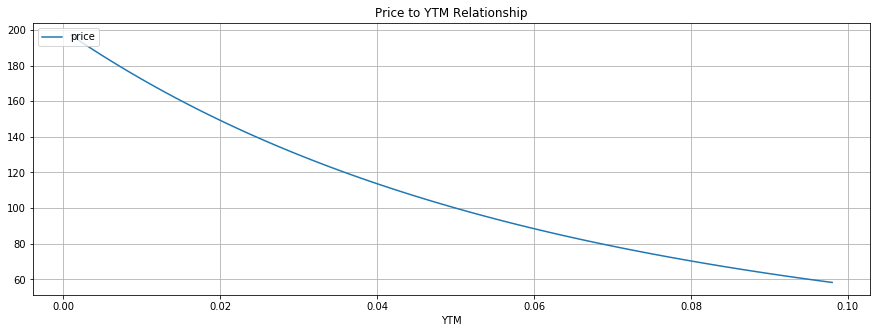

In [5]:
price_df = price_ytm_curve(facevalue=100, couponrate=0.05, tenor=20, periodicity=2, yt_range=np.arange(0.0,0.1,0.001))
price_df.index = price_df["YTM"]
price_df["price"].plot(title="Price to YTM Relationship",figsize=(15,5));
plt.legend(loc='upper left')
plt.grid(True)

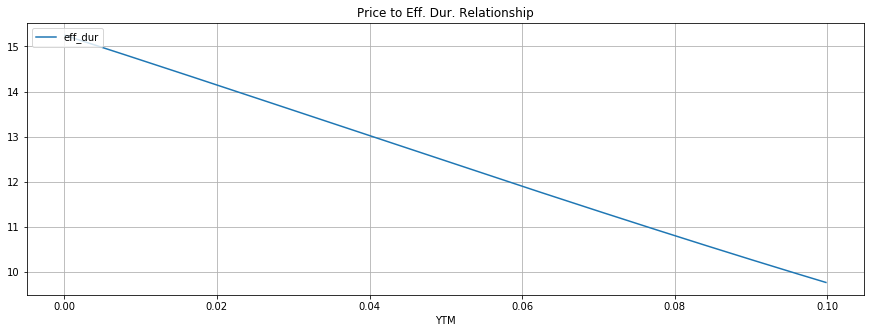

In [6]:
price_df = price_ytm_curve(facevalue=100, couponrate=0.05, tenor=20, periodicity=1, yt_range=np.arange(0.0,0.1,0.0001))
price_df.index = price_df["YTM"]
price_df["eff_dur"].plot(title="Price to Eff. Dur. Relationship",figsize=(15,5));
plt.legend(loc='upper left')
plt.grid(True)

Open list of to dos: 
* bring in call and put option features into second function. The effective duration function wouldn't change
* calculate convexity with one of the CFA L1 formulas 
* value the bonds not via dcf but with binomial tree from level 2 -> also include call and put option features
* Apply it to the real world by getting real values from treasury.gov and FRED. Adjust formulas to accurately price real bonds depending on actual day and day of next coupons etc (i.e. losen assumption that we are at inception or at coupon payment date). Apply it to actual bonds


In [55]:


print(price_ytm_curve(facevalue=100, couponrate=0.01, tenor=1, periodicity=1, yt_range=np.arange(0.0788,0.0792,0.0002))["eff_dur"][0])
print(price_ytm_curve(facevalue=100, couponrate=0.01, tenor=100, periodicity=1, yt_range=np.arange(0.0788,0.0792,0.0002))["eff_dur"][0])
print(price_ytm_curve(facevalue=100, couponrate=0.01, tenor=1000, periodicity=1, yt_range=np.arange(0.0788,0.0792,0.0002))["eff_dur"][0])

0.9267840911557297
12.926452544745288
12.658308978105092
